## 슬라이딩 윈도우 예제

### 필요한 패키지 설치

In [22]:
!pip install tensorflow==2.2.0
!pip install imutils
!pip install opencv-python
!pip install opencv-contrib-python

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


### 코드 zip 파일 다운로드

In [2]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/classifier-to-detector/classifier-to-detector.zip
!unzip -qq classifier-to-detector.zip
%cd classifier-to-detector

--2023-05-21 15:39:52--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/classifier-to-detector/classifier-to-detector.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.213.137, 3.5.82.11, 3.5.80.199, ...
접속 pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.213.137|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 245561 (240K) [binary/octet-stream]
Saving to: ‘classifier-to-detector.zip’

classifier-to-detec 100%[===================>] 239.81K   579KB/s    in 0.4s    

2023-05-21 15:39:53 (579 KB/s) - ‘classifier-to-detector.zip’ saved [245561/245561]

/workspace/IYDgySjn6TKLn4kDcR/classifier-to-detector


### 패키지 import

In [9]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from pyimagesearch.detection_helpers import sliding_window
from pyimagesearch.detection_helpers import image_pyramid
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2

### jupyter notebook 에서 이미지 표시

In [10]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

### 이미지 피라미드 및 슬라이딩 윈도우 유틸리티 기능 구현

In [45]:
from PIL import Image
import cv2 
import IPython.display as display

# Load image
image = cv2.imread("images/stingray.jpg")

# Define the window size
window_size = (64, 64)

# Define the step size
step_size = (8, 8)

# Define how many steps to take in x and y directions
x_steps = np.arange(0, image.shape[1] - window_size[1], step_size[0])
y_steps = np.arange(0, image.shape[0] - window_size[0], step_size[1])

for y in y_steps:
    for x in x_steps:
        # Extract the window from the image
        window = image[y:y + window_size[1], x:x + window_size[0]]

        clone = image.copy()
        # Here is where you would add your object detection code. 
        # For now we will just draw a rectangle around the window.
        cv2.rectangle(clone, (x, y), (x + window_size[0], y + window_size[1]), (255, 0, 0), 2)
        clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
        display.clear_output(wait=True)
        display.display(Image.fromarray(clone))

KeyboardInterrupt: 

In [11]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [42]:
from PIL import Image
import cv2 
import IPython.display as display

# Load your image
image = cv2.imread("images/stingray.jpg")

# Define window size and step size
window_size = (64, 64)  # (width, height)
step_size = 8

# Iterate through the sliding windows
for (x, y, window) in sliding_window(image, step_size, window_size):
    if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
        continue

    # Optionally, visualize the sliding windows
    clone = image.copy()
    cv2.rectangle(clone, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
    clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
#     plt_imshow("aaa", clone)
    display.clear_output(wait=True)
    display.display(Image.fromarray(clone))

KeyboardInterrupt: 

In [12]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image

    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image

### 사전 학습된 이미지 분류자를 객체 감지기로 전환


In [13]:
args = {
    "image": "images/stingray.jpg",
    "size": "(300, 150)",
    "min_conf": 0.9,
    "visualize": -1
}

In [14]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224)

In [15]:
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

[INFO] loading network...
102973440/102967424 [==============================] - 1s 0us/step


In [16]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [17]:
# loop over the image pyramid
for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])

    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        # take the ROI and preprocess it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if args["visualize"] > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),
                (0, 255, 0), 2)

            # show the visualization and current ROI
            plt_imshow("Visualization", clone)
            plt_imshow("ROI", roiOrig)

In [18]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
    end - start))

# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
    end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

[INFO] looping over pyramid/windows took 40.40971 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 19.53255 seconds
40960/35363 [==================================] - 0s 1us/step


In [19]:
# loop over the predictions
for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]

    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= args["min_conf"]:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]

        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

[INFO] showing results for 'stingray'


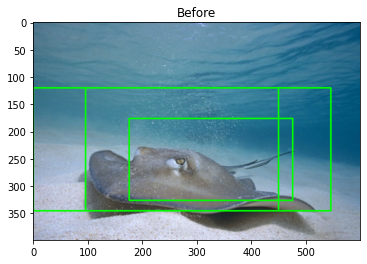

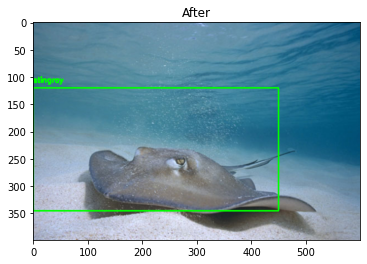

In [20]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    plt_imshow("Before", clone)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    # show the output after apply non-maxima suppression
    plt_imshow("After", clone)